In [2]:
from typing import List, Dict
from collections import Counter 
import math
import matplotlib.pyplot as plt

def bucketize(point: float, bucket_size: float) -> float:
    """ Floor the point to the next lower multiple of bucket_size """
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points: List[float], bucket_size:float) -> Dict[float, int]:
    """ Buckets the points and counts how many in each bucket """
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points: List[float], bucket_size: float, title: str = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)

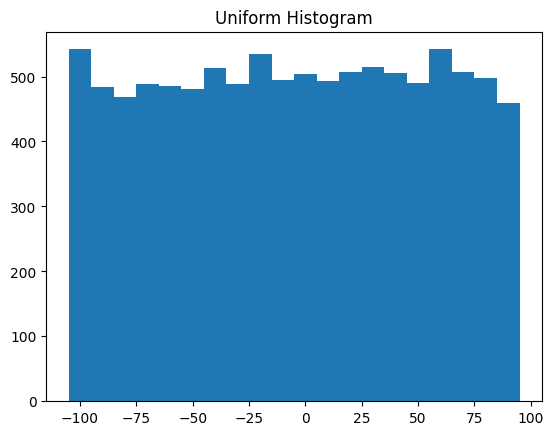

In [3]:
import random 
from Helper.Probabilty import inverse_normal_cdf

random.seed(0)

#uniform between -100 and 1000
uniform = [200 * random.random() - 100 for _ in range(10000)]

# normal distribution with mean 0, standard deviation 57
normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]

plot_histogram(uniform, 10, "Uniform Histogram")


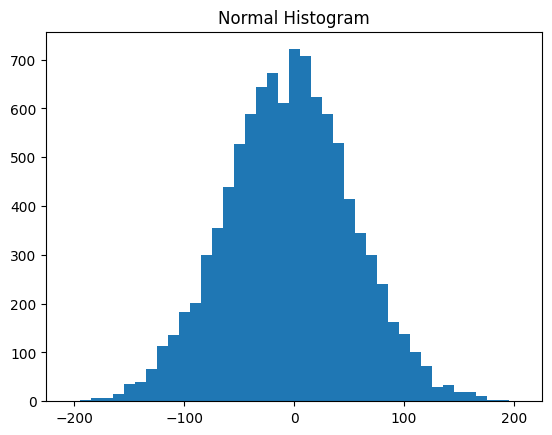

In [4]:
plot_histogram(normal, 10, "Normal Histogram")

In [5]:
def random_normal() -> float:
    """ Returns a random draw from a standard normal distribution  """

    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

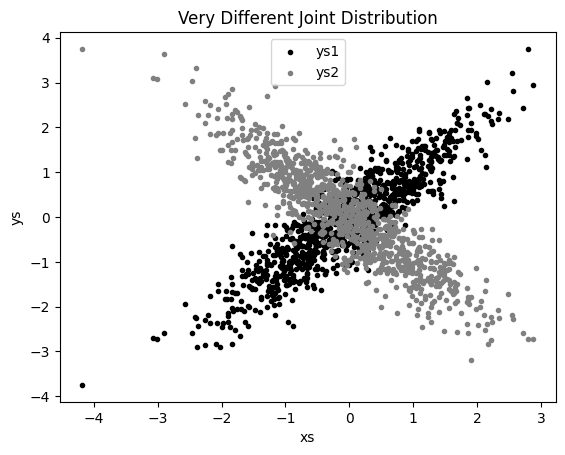

In [6]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc = 9)
plt.title("Very Different Joint Distribution")
plt.show()

In [7]:
from Helper import Linear_Algebra
from Helper.Statistics import correlations
Matrix  = List[List[float]]

def correlation_matrix( data: List[Linear_Algebra.Vector]) -> Matrix:
    """ 
    Returns the len(data) x len(data) matrix whose (i,j)-th entry
    is the correlation between data[i] and data [j]
    """
    def correlation_ij(i:int, j:int) -> float:
        return correlations(data[i], data[j])

    return Linear_Algebra.make_matrix(len(data), len(data), correlation_ij)

# Dataclasses 

In [8]:
from dataclasses import dataclass
import datetime

@dataclass
class StockPrice2:
    symbol: str
    date: datetime.date
    closing_price: float

    def is_high_tech(self) -> bool:
        """ It's a class, so we can add methods too """
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']
    
price = StockPrice2('MSFT', datetime.date(2018,12,14), 106.03)

assert price.symbol == 'MSFT'
assert price.closing_price == 106.03

In [9]:
from dateutil.parser import parse

def parse_row(row: List[str]) ->StockPrice2:
    symbol, date, closing_price = row
    return StockPrice2(symbol = symbol,
                       date = parse(date).date(),
                       closing_price=float(closing_price))

stock = parse_row(['MSFT', '2018-12-14', '106.03'])
assert price.symbol == 'MSFT'
assert price.closing_price == 106.03


In [10]:
from typing import Optional, List
import re
def try_parse_row(row: List[str]) -> Optional[StockPrice2]:
    symbol, date, closing_price = row
    # Stock symbol should be all capital letters
    if not re.match(r"^[A-Z]+$", symbol):
        print(1)
        return None
    
    try:
        date = parse(date).date()
    except ValueError:
        print(2)
        return None
    
    try:
        closing_price = float(closing_price)
    except ValueError:
        print(3)
        return None
    
    return StockPrice2(symbol=symbol, date= date, closing_price= closing_price)

assert try_parse_row(["MSFT ","2018-12-14","106.03"]) is None
assert try_parse_row(["MSFT","2018-12--14","106.03"]) is None
assert try_parse_row(["MSFT","2018-12-14","x"]) is None

1
2
3


In [11]:
import csv
data = []
with open("Helper/stocks.txt",'r') as f:
    reader = csv.DictReader(f, delimiter='\t')
    for row in reader:
        date = str(row['date'])
        symbol = row['symbol']
        closing_price = str(row['closing_price'])
        data.append(try_parse_row(row.values()))        
        

In [12]:
max_aapl_price = max(stock_price.closing_price
                     for stock_price in data
                     if stock_price.symbol == "AAPL")

print(max_aapl_price)

119.0


In [13]:
from collections import defaultdict

max_prices : Dict[str, float] = defaultdict(lambda: float('-inf'))

for sp in data:
    symbol, closing_price = sp.symbol, sp.closing_price
    if closing_price > max_prices[symbol]:
        max_prices[symbol] = closing_price

In [14]:
from typing import List
from collections import defaultdict

# Collect the prices by symbol
prices : Dict[str, List[StockPrice2]] = defaultdict(list)

for sp in data:
    prices[sp.symbol].append(sp)

In [15]:
# Order the prices by date
prices = {symbol: sorted(symbol_prices)
          for symbol, symbol_prices in prices.items()}

TypeError: '<' not supported between instances of 'StockPrice2' and 'StockPrice2'

In [16]:
data = [[1, 20, 2],
            [1, 30, 3],
            [1, 40, 4]]

from typing import Tuple

from Helper.Linear_Algebra import vector_mean
from Helper.Statistics import standard_deviations

Vector = List[float]
def scale(data: List[Vector]) -> Tuple[Vector, Vector]:
    """  Returns the Mean and Standard Deviations for each position"""
    dim = len(data[0])

    means = vector_mean(data)
    stdevs = [standard_deviations([vector[i] for vector in data]) 
              for i in range(dim)]
    
    return means, stdevs


In [17]:
vectors = [[-3, -1, 1], [-1, 0, 1], [1, 1, 1]]
means, stdevs = scale(vectors)

assert means == [-1, 0, 1]
assert stdevs == [2, 1, 0]

In [18]:
def rescale(data: List[Vector]) -> List[Vector]:
    """ 
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position 
    as is if its standard deviation is 0.)
    """

    dim = len(data)
    means, stdevs = scale(data)

    # Make a copy of each vector 
    rescaled = [v[:] for v in data]

    for v in rescaled:
        for i in range(dim):
            if stdevs[i] >0:
                v[i] = (v[i] - means[i]) / stdevs[i]
    return rescaled


In [19]:
means, stdevs = scale(rescale(vectors))
print(means, stdevs)
assert means == [0, 0, 1]
assert stdevs == [1, 1, 0]

[0.0, 0.0, 1.0] [1.0, 1.0, 0.0]


In [20]:
! pip install tqdm


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [21]:
import tqdm

for i in tqdm.tqdm(range(100)):
    # Try something slow
    _ = [random.random() for _ in range(1000000)]

100%|██████████| 100/100 [00:10<00:00,  9.42it/s]


In [22]:
from typing import List

def primes_up_to(n: int) -> List[int]:
    primes =[2]
    with tqdm.trange(3, n) as t:
        for i in t:
            # i is prime if no smaller prime divides it
            i_is_prime = not any( i%p == 0 for p in primes)
            if i_is_prime:
                primes.append(i)
            
            t.set_description(f'{len(primes)} primes')
    return primes
my_primes = primes_up_to(100_000)

9592 primes: 100%|██████████| 99997/99997 [01:40<00:00, 997.38it/s] 


PCA


In [23]:
from Helper.Linear_Algebra import sub

def de_mean(data: List[Vector]) -> List[Vector]:
    """ Recenters the data to have a mean 0 in every dimension """

    mean = vector_mean(data)
    return [sub(vector,mean) for vector in data]


In [24]:
from Helper.Linear_Algebra import magnitude

def direction(w: Vector) -> Vector:
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

In [25]:
from Helper.Linear_Algebra import dot

def directional_variance(data: List[Vector], w: Vector) -> float:
    """ Returns the variance of x in the direction of w """

    w_dir = direction(w)
    return sum(dot(v, w_dir) **2 for v in data)


In [26]:
def directional_variance_gradient(data: List[Vector], w:Vector) -> Vector:
    """  
    The gradient of directional variance with respect to w
    """
    w_dir = direction(w)
    return [sum(2 * dot(v, w_dir) * v[i] for v in data) for i in range(len(w))
            ]

In [27]:
from Helper.Gradient_Descent import gradient_step

def first_principal_components(data: List[Vector],
                               n:int = 100,
                               step_size: float = 0.1) -> Vector:
    
    # Start with the random guess
    guess = [1.0 for _ in data[0]]

    with tqdm.trange(n) as t:
        for _ in t:
            dv = directional_variance(data, guess)
            gradient = directional_variance_gradient(data, guess)
            guess = gradient_step(guess, gradient, step_size)
            t.set_description(f' dv: {dv:3f}')

    return direction(guess)

[8.254493818906973, 3.1612488780585473, 7.997874651106372]
0 [8.089403942528833, 3.098023900497376, 7.837917158084244]
1 [7.927615863678256, 3.0360634224874286, 7.68115881492256]
2 [7.769063546404691, 2.97534215403768, 7.527535638624109]
3 [7.613682275476598, 2.9158353109569264, 7.376984925851627]
4 [7.461408629967066, 2.857518604737788, 7.229445227334594]
5 [7.312180457367725, 2.800368232643032, 7.0848563227879024]
6 [7.16593684822037, 2.7443608679901716, 6.943159196332145]
7 [7.022618111255962, 2.6894736506303683, 6.804296012405502]
8 [6.882165749030843, 2.635684177617761, 6.668210092157392]
9 [6.744522434050227, 2.5829704940654055, 6.534845890314244]
10 [6.609631985369222, 2.5313110841840976, 6.40414897250796]
11 [6.477439345661837, 2.4806848625004156, 6.2760659930578]
12 [6.347890558748601, 2.4310711652504073, 6.150544673196644]
13 [6.220932747573629, 2.382449741945399, 6.027533779732711]
14 [6.096514092622156, 2.3348007471064913, 5.906983104138057]
15 [5.974583810769713, 2.2881047

In [28]:
from Helper.Linear_Algebra import scalar_multiply

def project(v:Vector, w: Vector) -> Vector:
    """ Return the projection of v onto the direction w """

    projection_length = dot(v,w)

    return scalar_multiply(projection_length, w)

In [32]:
from Helper.Linear_Algebra import sub

def remove_projection_from_vector(v: Vector, w: Vector) -> Vector:
    """ Projects v onto w and subtracts the results from v  """

    return sub(v, project(v,w))

def remove_projection(data: List[Vector], w:[Vector]) -> List[Vector]:
    return [remove_projection_from_vector(v, w) for v in data]

In [33]:
def pca(data: List[Vector], num_components: int) -> List[Vector]:
    components: List[Vector] = []
    for _ in range(num_components):
        component = first_principal_components(data)
        components.append(component)
        data = remove_projection(data, component)

    return components

def transform_vector(data: List[Vector], components: List[Vector]) -> List[Vector]:
    return [dot(v,w) for w in components]

def transform(data: List[Vector], components: List[Vector]) -> List[Vector]:
    return [transform_vector(v,components) for v in data]
